In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.INLP import *
import Scripts.utils as utils

In [2]:
import codecs
import json
import numpy as np
import sklearn
from sklearn.svm import LinearSVC, SVC


In [4]:
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [5]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [6]:
np.isnan(vectors).any()

False

In [7]:
#Gender specific vocabulary:
gender_specific=[]
with open('./Data/male_word_file.txt') as f:
    gender_specific = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [8]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab, exclude=gender_specific)

100%|██████████| 400000/400000 [00:00<00:00, 614695.27it/s]


Size of limited vocabulary: 326614


In [9]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian"],
		["african", "caucasian", "asian"],
		["black", "white", "asian"],
		["africa", "america", "asia"],
		["africa", "america", "china"],
		["africa", "europe", "asia"]
    ], 
    "religion":[
		["judaism", "christianity", "islam"],
		["jew", "christian", "muslim"],
    ["synagogue", "church", "mosque"],
    ["torah", "bible", "quran"],
    ["rabbi", "priest", "imam"]
	]}

In [10]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

### INLP

In [12]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)


In [13]:
num_vectors_per_class = 7500

gender_direction = identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
gender_direction = np.squeeze(gender_direction)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
fem_words_and_scores, masc_words_and_scores, neut_words_and_scores = getting_classes_for_INLP(
    gender_vector=gender_direction, model=model_original, n=7500)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

#getting the vectors corresponding to masc_words from the dict_vec_cleaned
masc_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in masc_words]
fem_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in fem_words]
neut_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in neut_words]

#turn the list of vectors into a numpy array
masc_vecs=np.array(masc_vecs)
fem_vecs=np.array(fem_vecs)
neut_vecs=np.array(neut_vecs)

#masc_vecs, fem_vecs = model_original.get_vectors_from_list(masc_words), model_original.get_vectors_from_list(fem_words)
#neut_vecs = model_original.get_vectors_from_list(neut_words)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.zeros(n, dtype = int),
                                                  np.ones(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC:",masc_words[:50] )
print("-------------------------")
print("TOP FEM:", fem_words[:50])
print("-------------------------")
print("Random Neutral:", neut_words[:50])

Length of vectors set: 2
Running PCA with 1 components
TOP MASC: ('john', 'frankenheimer', 'thune', 'toshack', 'hillcoat', 'shadegg', 'salley', 'celestand', 'bitove', 'hostettler', 'hickenlooper', 'prine', 'tradescant', 'krimsky', 'afoa', 'frusciante', 'arne', 'kufuor', 'prescott', 'xxii', 'mauceri', 'mayall', 'kibowen', 'paintsil', 'feehery', 'batiste', 'fogerty', 'motson', 'varvatos', 'kampfner', 'hyoon', 'murtha', 'demjanjuk', 'malkovich', 'leclair', 'cornyn', 'pilger', 'mellencamp', 'strype', 'karlheinz', 'mcdouall', 'baldessari', 'chastelain', 'tchicai', 'fashanu', 'kyl', 'holecek', 'hancock', 'senden', 'hamre')
-------------------------
TOP FEM: ('mary', 'seacole', 'aldermanbury', 'frann', 'oblates', 'gaitskill', 'rajskub', 'woolnoth', 'magdalene', 'poppins', 'queenship', 'wollstonecraft', 'matalin', 'servites', 'woronov', 'selecky', 'magdelene', 'engelbreit', 'fackler', 'pipher', 'retton', 'immaculate', 'steenburgen', 'malgoire', 'nagu', 'mcaleese', 'sasami', 'oakar', 'wigman', 

In [14]:
#random.seed(42)
np.random.seed(42)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10875; Dev size: 4662; Test size: 6659


In [15]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'penalty': 'l2','fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'penalty': 'l2','fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
dropout_rate = 0


In [17]:
P, rowspace_projs, Ws = get_debiasing_projection(gender_clf, params, n, 300, min_acc, 
                                    X_train, Y_train, X_dev, Y_dev, 
                                    is_autoregressive=True, Y_train_main=None, Y_dev_main=None, 
                                       dropout_rate = 0)

iteration: 34, accuracy: 0.34191334191334194: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


## Evaluation

In [18]:
from Scripts.Visualization import *
from Scripts.Evaluation import *

## Pre_post bias selected words

In [19]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']



In [20]:
# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)


In [21]:
debiased_vectors=(P.dot(vectors_cleaned.T)).T
debiased_dict=get_debiased_dict(debiased_vectors, word2idx_cleaned)
debiased_vocab = list(debiased_dict.keys())



In [22]:
gender_bias_after_debiasing = compute_gender_simple_bias(
    debiased_dict, he_embed, she_embed)


In [23]:
bias_df = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, occupations, vocab_cleaned, debiased_vocab)
plot_bias_bar(
    bias_df, plot_title="INLP bias", words_title='words')


## Clustering

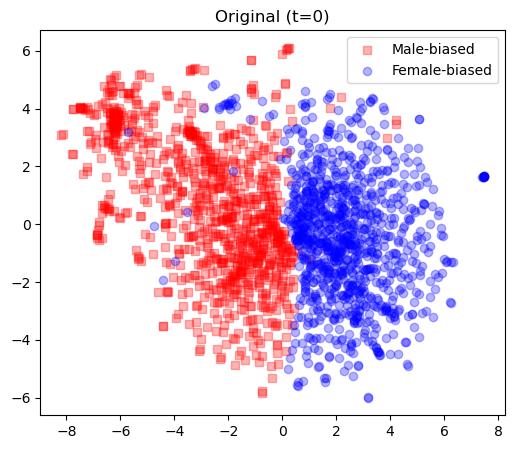

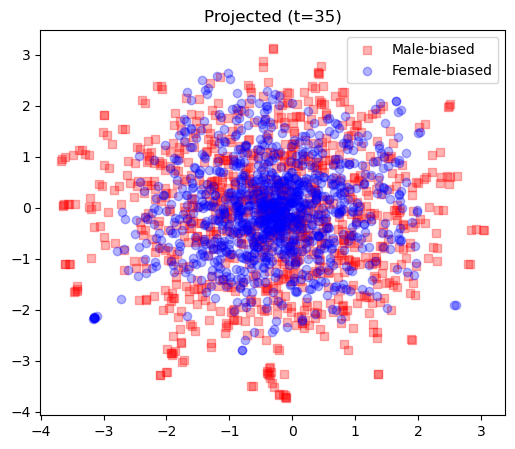

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

V-measure-before (TSNE space): 0.3658342551956882
V-measure-after (TSNE space): 0.002125214782196269
V-measure-before (original space): 0.2587627913155871
V-measure-after (original space): 0.000384492026470635
Rank before: 300; Rank after: 195


In [24]:

# remove neutral class, keep only male and female biased
X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M = 2000
ind2label = {1: "Female-biased", 0: "Male-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(
    all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title="Original (t=0)", ind2label=ind2label)


X_dev_cleaned = (P.dot(X_dev.T)).T
X_test_cleaned = (P.dot(X_test.T)).T
X_trained_cleaned = (P.dot(X_train.T)).T
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M],
                  title="Projected (t={})".format(n), ind2label=ind2label)

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before,
      all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after,
      all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(
    all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k=2))
print("V-measure-after (original space): {}".format(
    compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k=2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))


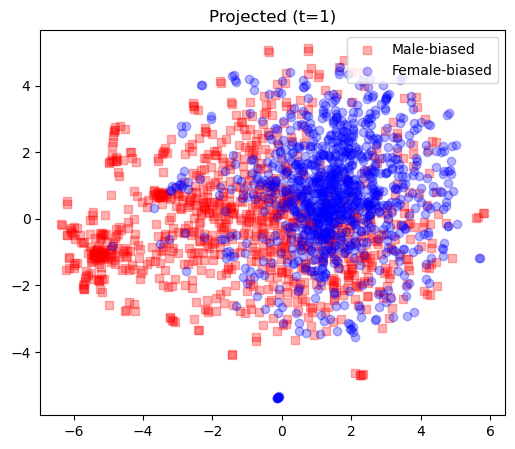

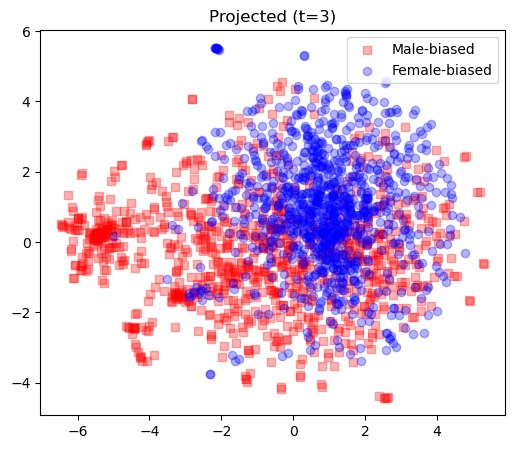

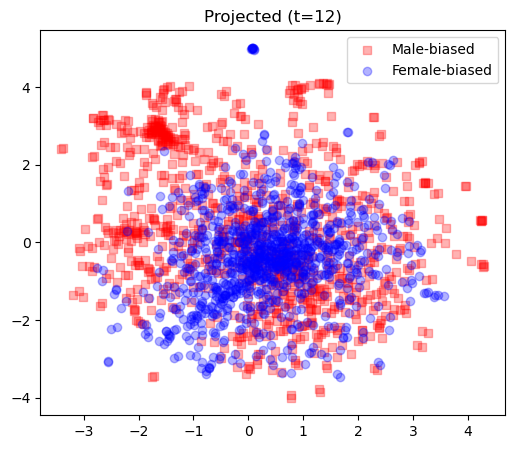

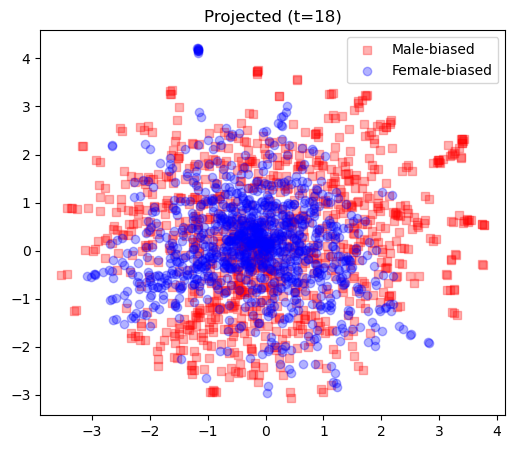

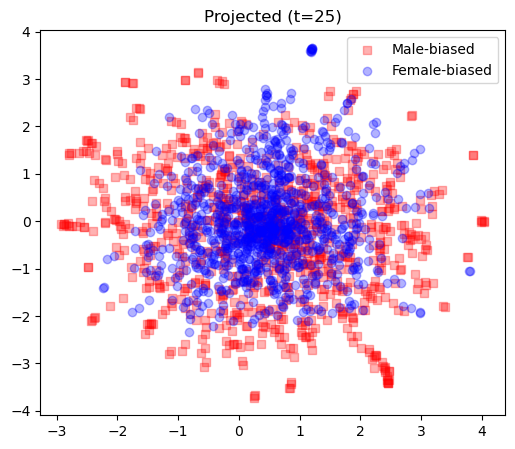

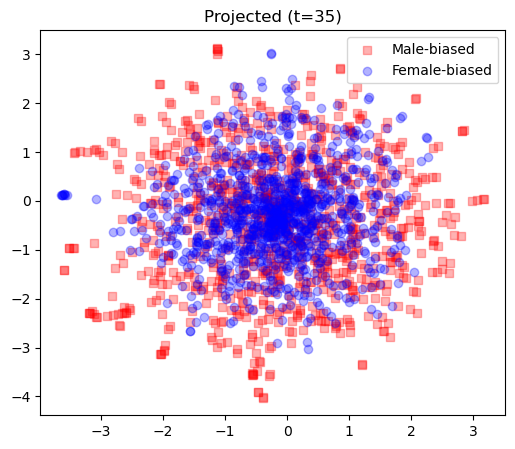

In [26]:
for t in [1, 3, 12, 18, 25, 35]:
    p = get_projection_to_intersection_of_nullspaces(rowspace_projs[:t], 300)
    tsne_after = tsne(p.dot(all_significantly_biased_vecs[:M].T).T, all_significantly_biased_labels[:M], title="Projected (t={})".format(
        t), ind2label=ind2label)


## Random Words

In [57]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [58]:
random_words


array(['enjoyed', 'actua', 'dysmorphic', 'leeuwenhoek', 'fortiers',
       'vyksa', 'ōkubo', 'hueneme', 'moutai', 'nappers', 'zhifu', 'quek',
       'samjhauta', 'ventoux', 'uchiyamada', 'changelings', 'schwanitz',
       'sidgmore', 'ta', 'frp', 'herpesviruses', 'kharmato', 'treuhaft',
       'projectors', 'kanno', 'pettyfer', 'histotroph', 'wacholder',
       'ramsdell', 'peñón', 'piaa', 'udps', 'carsley', 'caught', 'udaya',
       'goriest', 'laubscher', 'socachy', 'kallman', 'nonscientific',
       'ministerial', 'herbinger', 'pericoronitis', 'telomere', 'tarabay',
       'lieb', 'hermance', 'mawer', 'maily', 'contort'], dtype='<U19')

In [59]:

model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 300)


In [60]:
finding_neighbors_before_after(
    random_words, model_original, model_debiased, topn=3)


----------------------------------
word: enjoyed
 most-similar-before: ('enjoying', 'enjoy', 'enjoys')
 most-similar-after: ('enjoying', 'enjoys', 'enjoy')
----------------------------------
word: actua
 most-similar-before: ('yûgi', 'kōkō', 'fushigi')
 most-similar-after: ('tokimeki', 'strider', 'kōkō')
----------------------------------
word: dysmorphic
 most-similar-before: ('dysmorphia', 'somatization', 'hypochondriasis')
 most-similar-after: ('dysmorphia', 'body', 'disorder')
----------------------------------
word: leeuwenhoek
 most-similar-before: ('wijngaarden', 'microscopist', 'meteren')
 most-similar-after: ('van', 'wijngaarden', 'campen')
----------------------------------
word: fortiers
 most-similar-before: ('ciprianis', 'hartmans', 'goldsteins')
 most-similar-after: ('hartmans', 'ciprianis', 'petersons')
----------------------------------
word: vyksa
 most-similar-before: ('dolgoprudny', 'dagdizel', 'liski')
 most-similar-after: ('dolgoprudny', 'dagdizel', 'novotroitsk')


defaultdict(dict,
            {'enjoyed': {'before': ('enjoying', 'enjoy', 'enjoys'),
              'after': ('enjoying', 'enjoys', 'enjoy')},
             'actua': {'before': ('yûgi', 'kōkō', 'fushigi'),
              'after': ('tokimeki', 'strider', 'kōkō')},
             'dysmorphic': {'before': ('dysmorphia',
               'somatization',
               'hypochondriasis'),
              'after': ('dysmorphia', 'body', 'disorder')},
             'leeuwenhoek': {'before': ('wijngaarden',
               'microscopist',
               'meteren'),
              'after': ('van', 'wijngaarden', 'campen')},
             'fortiers': {'before': ('ciprianis', 'hartmans', 'goldsteins'),
              'after': ('hartmans', 'ciprianis', 'petersons')},
             'vyksa': {'before': ('dolgoprudny', 'dagdizel', 'liski'),
              'after': ('dolgoprudny', 'dagdizel', 'novotroitsk')},
             'ōkubo': {'before': ('toshimichi', 'ōmura', 'nabeshima'),
              'after': ('toshimichi',

In [61]:
from sklearn.manifold import TSNE
import numpy as np

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased, 20)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


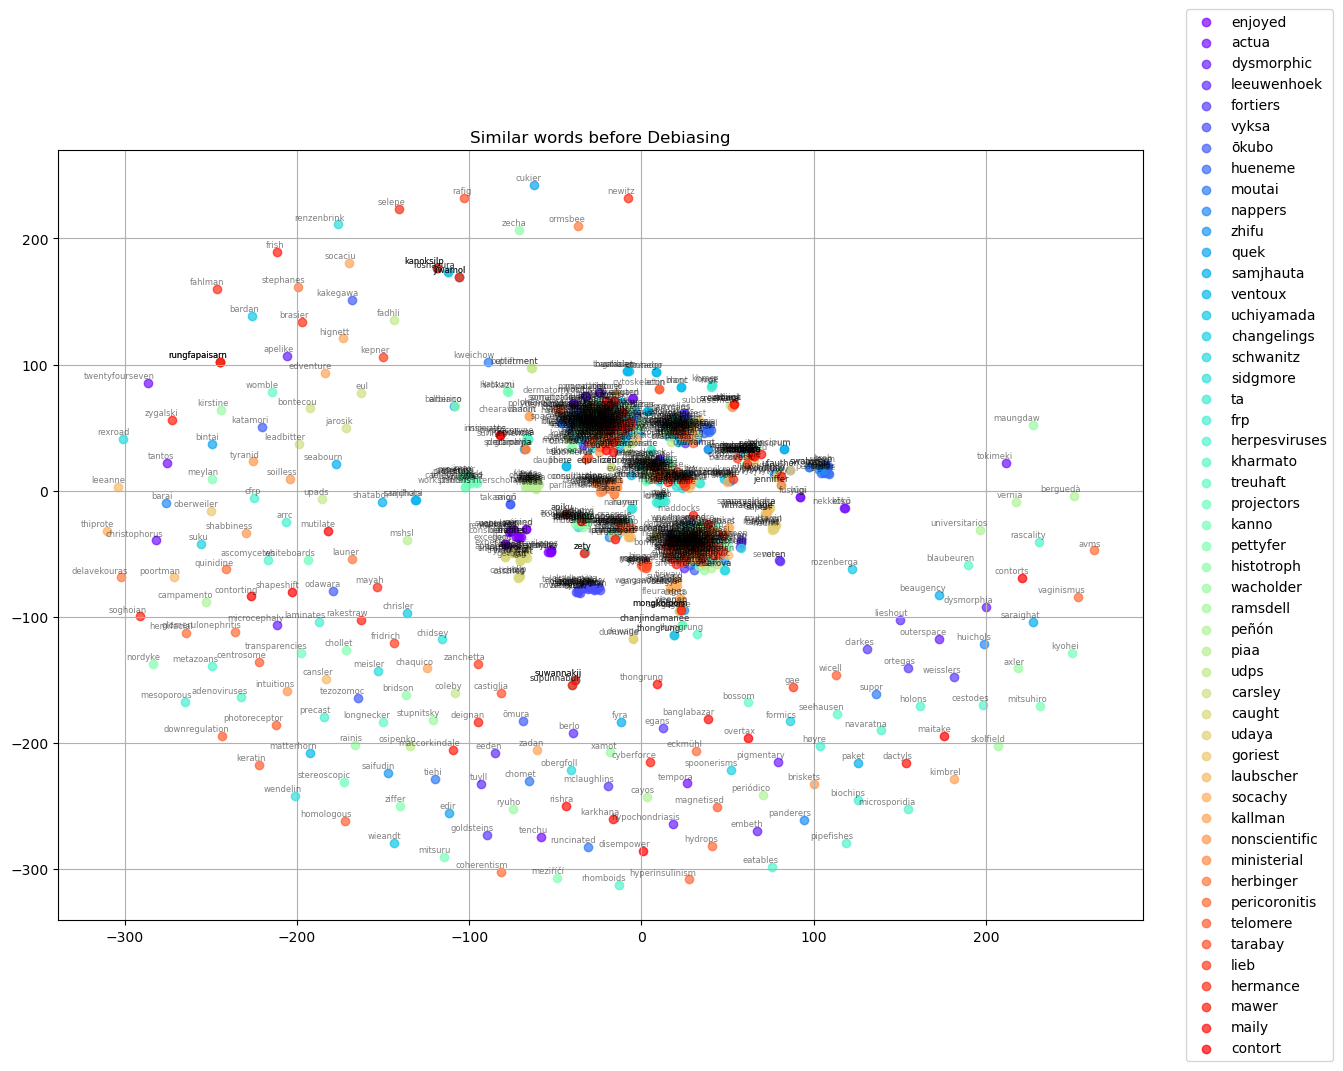

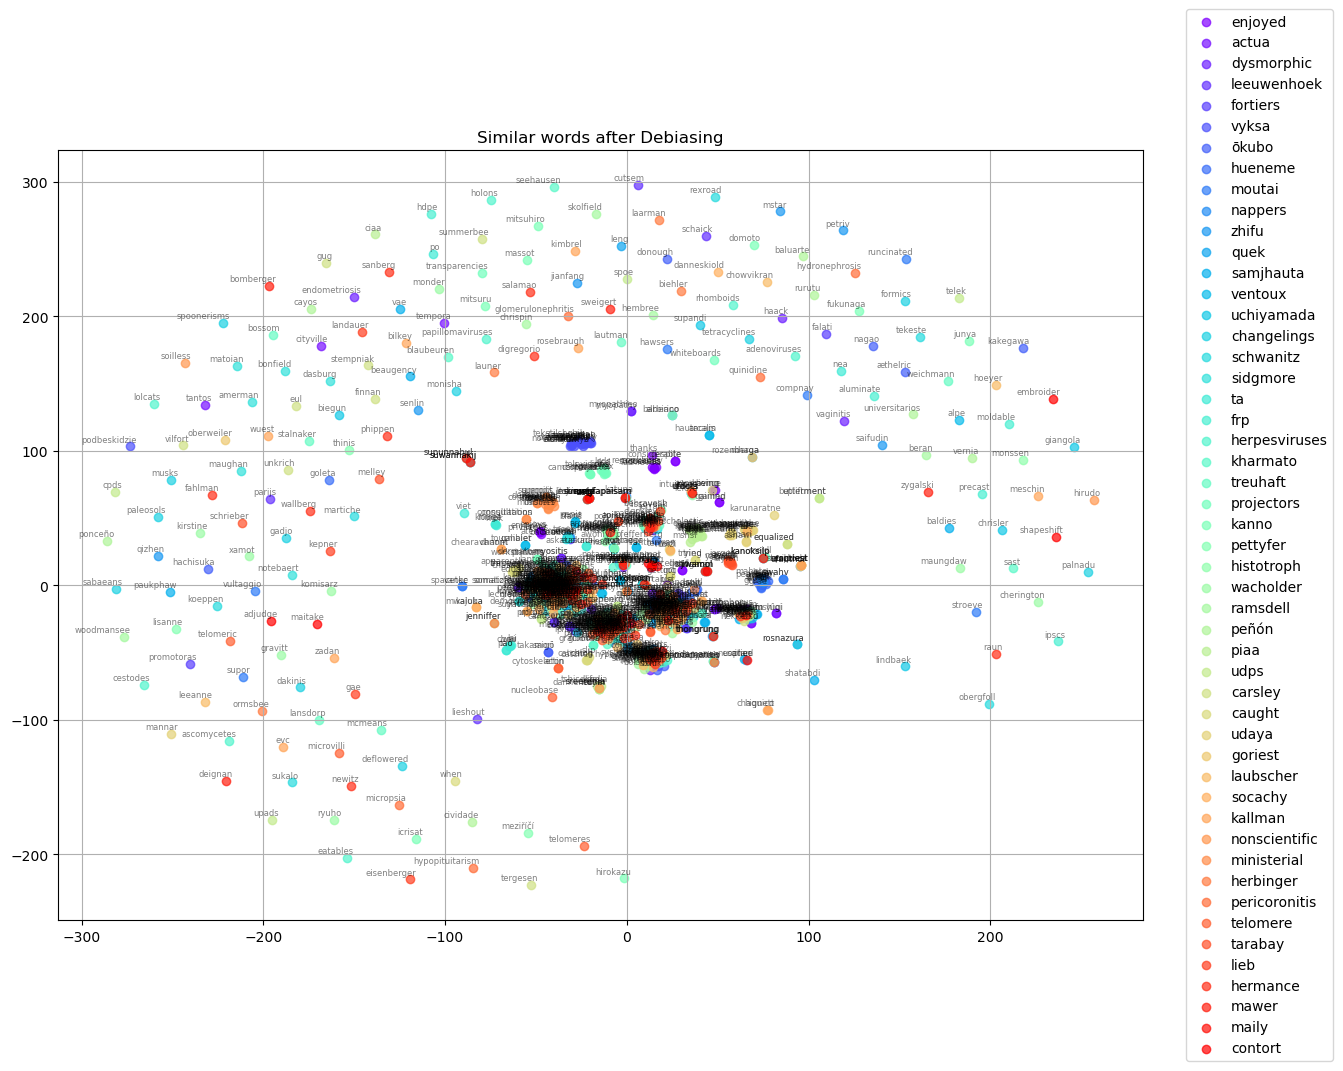

In [62]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [63]:
gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
                 # "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after=finding_neighbors_before_after(gendered_names, model_original, model_debiased, topn=3)

----------------------------------
word: ruth
 most-similar-before: ('bader', 'ginsburg', 'maris')
 most-similar-after: ('bader', 'gehrig', 'ginsburg')
----------------------------------
word: charlotte
 most-similar-before: ('carolina', 'hornets', 'raleigh')
 most-similar-after: ('hornets', 'bobcats', 'raleigh')
----------------------------------
word: abigail
 most-similar-before: ('breslin', 'thernstrom', 'abby')
 most-similar-after: ('breslin', 'thernstrom', 'abby')
----------------------------------
word: sophie
 most-similar-before: ('elisabeth', 'louise', 'anne')
 most-similar-after: ('mongalvy', 'marceau', 'elisabeth')
----------------------------------
word: nichole
 most-similar-before: ('nordeman', 'cortney', 'lestrac')
 most-similar-after: ('nordeman', 'monroe', 'warhawks')
----------------------------------
word: emma
 most-similar-before: ('emily', 'julia', 'kate')
 most-similar-after: ('bonino', 'bovary', 'grint')
----------------------------------
word: olivia
 most-sim

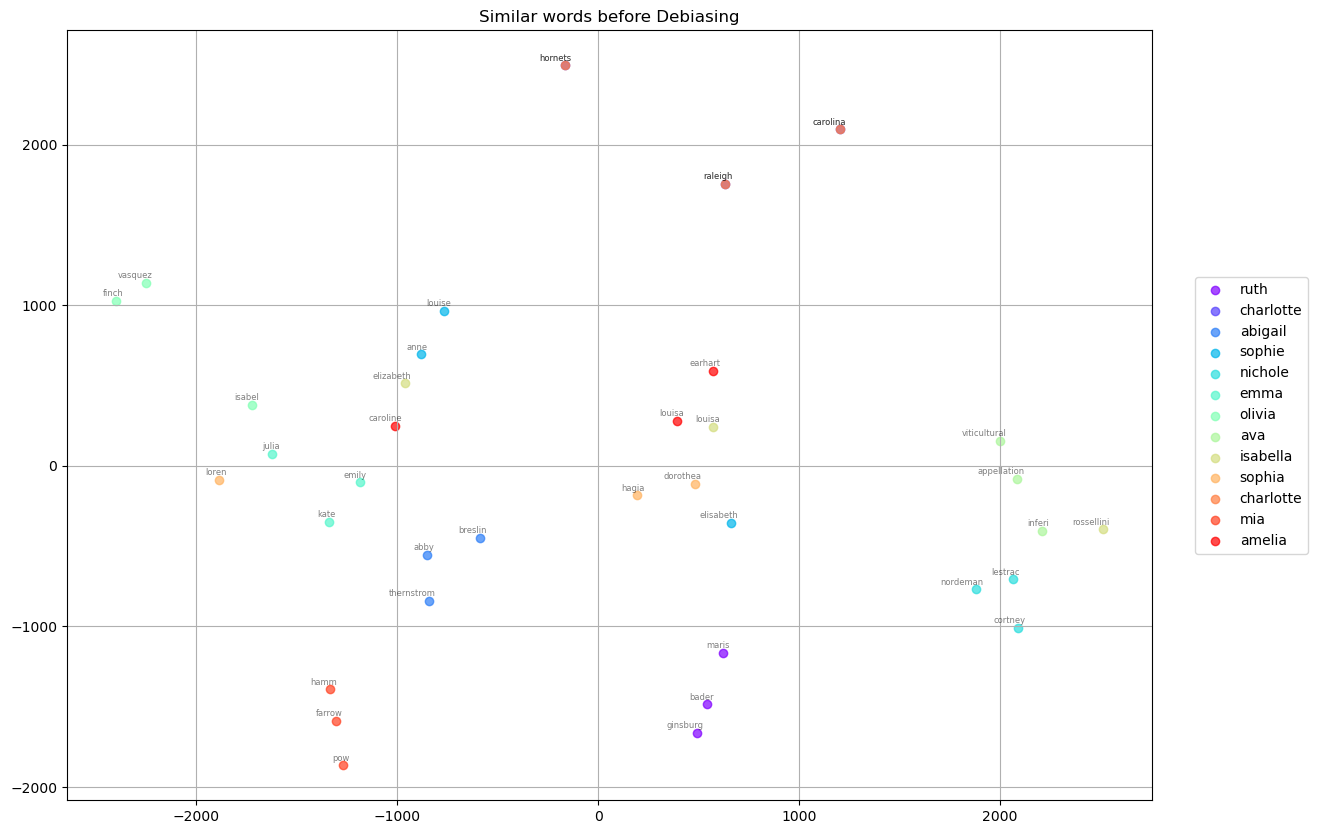

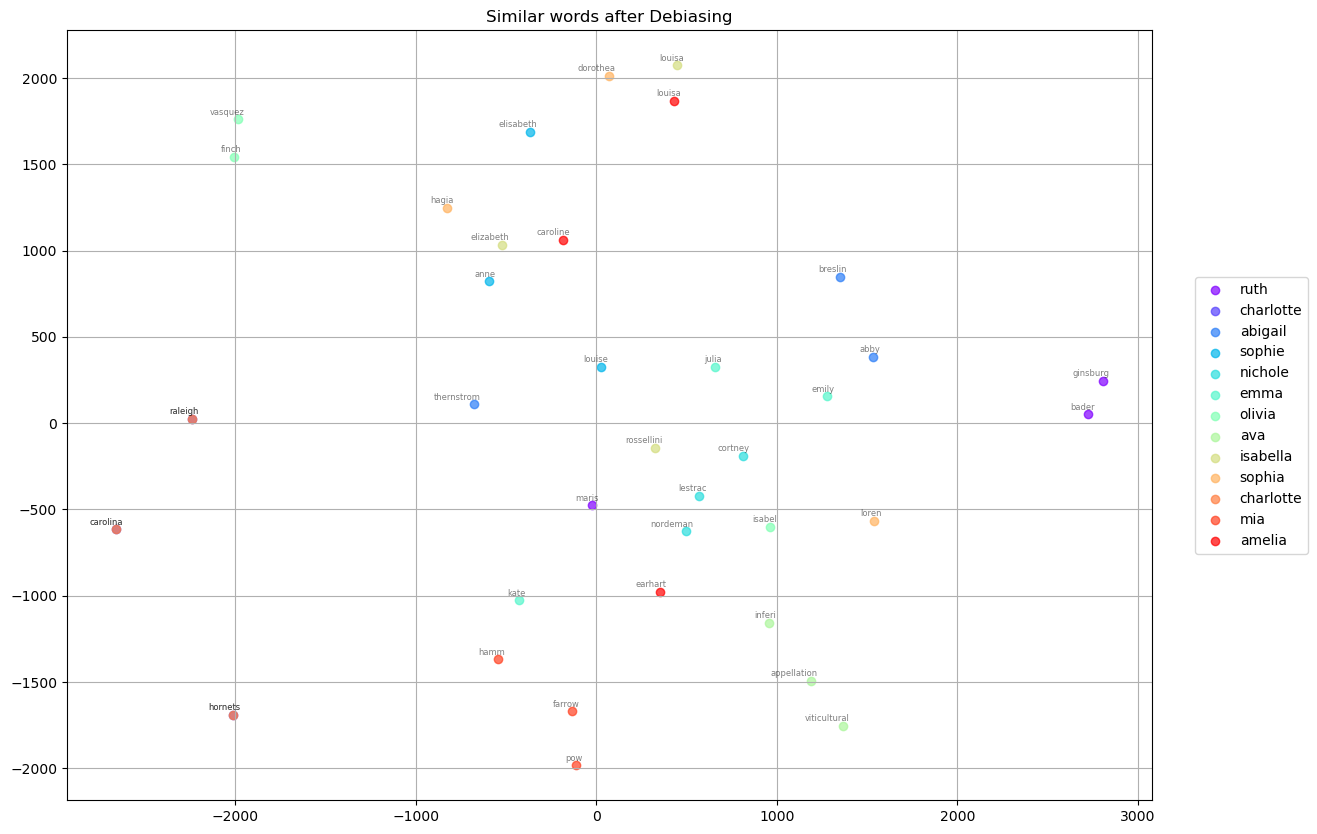

In [64]:
keys2 = gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing',
                        keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


#### Neighbor Analysis

In [65]:
inlp_vectors = (P.dot(vectors_cleaned.T)).T
inlp_dict = get_debiased_dict(inlp_vectors, word2idx_cleaned)
inlp_vocab = list(inlp_dict.keys())


In [66]:
k_neigh = get_k_nearest_neighbors(
    random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

list_neigh = get_list_neighbors(k_neigh)
inlp_freq = get_frequency_original_neighbors(
    random_words, list_neigh, inlp_dict, inlp_vocab, inlp_vectors, word2idx_cleaned, neighbours_num=50)


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]
1it [00:02,  2.17s/it]

enjoying
enjoys
enjoy
popularity
benefited
thanks
success
gained
privileges
afforded
prosperity
achieved
acclaim
phenomenal
gaining
considerable
remarkable
advantages
having
tremendous
excellent
witnessed
liked
accustomed


2it [00:04,  2.17s/it]

tokimeki
strider
kōkō
fushigi
cityville
stöð
trackmania
nekketsu
jinsei
valkyria
yûgi
drakengard
tenchu
christophorus
peligro
planetside
secreta
boum
splatterhouse


3it [00:06,  2.16s/it]

dysmorphia
myositis
haack
myopathy
somatization
myopathies
endometriosis
pigmentary
patdowns
bdd
somatoform
asperger
embeth
architectonic
apelike
damiana
hypochondriasis


4it [00:08,  2.16s/it]

wijngaarden
campen
microscopist
nieuwenhuizen
meteren
abbemuseum
cutsem
lieshout
antonie
severen
noten
harpen
kiliaen
helmont
everdingen
eeden
schaick
meegeren
duyn
juvarra
wouw
hise
arkel
parijs
meulen
visscher
dugua
zanten


5it [00:10,  2.17s/it]

hartmans
ciprianis
petersons
gravelles
goldsteins
weisslers
egans
madisons
sweeneys
tracys
waksals
ortegas
camdens
klines
shepards
terrys
netanyahus
greenes
bermans
menils
mehtas
ezzos
robersons
clarkes
cappadocians
collinses
kaufmans
promotoras
fayeds
mclaughlins
macheyo
nords
saulles


6it [00:13,  2.17s/it]

dolgoprudny
dagdizel
novotroitsk
liski
volochyok
sibiryak
gornyak
yakutiya
nosta
vyshny
angusht
ryzdvyany
volzhsky
tekstilshchik
syzran
slavyansky
metallurg
chelny
oktan
kaspiysk
naberezhnye
neftekhimik
shenxin
bratsk
podbeskidzie
tofaga
truda
akademiya
smena
diósgyőri
simurq
strogino
persiba
hoverla
grödig
gubkin
naftan
soligorsk


7it [00:15,  2.17s/it]

toshimichi
odawara
daimyō
ōmura
nabeshima
kakegawa
cragen
mōri
fyans
isachsen
saigō
hachisuka
nagao
baley
naitō
umayya
bhoite
gallarate
tezozomoc


8it [00:17,  2.17s/it]

wy
leem
poway
brindisi
shahk
gree
thoo
weye
suhl
gricar
nehustan
riht
stebic
oxnard
kly
keem
droo
tahp
connetquot
szuszka
druh
srih
laglio
hamze
breh
yool
tisk
goleta
hedland
hesperia
tanak


9it [00:19,  2.17s/it]

kweichow
maotai
vanke
yanzhou
hawsers
chalco
rocknrolla
chomet
maanshan
unisem
eleme
tiehi
compnay
nufarm
powertek
stroeve


10it [00:21,  2.17s/it]

rahb
zayr
simbach
burkha
barai
dreen
swahv
ified
perungudi
ameriya


11it [00:23,  2.17s/it]

yanwei
qizhen
mstar
ndungu
jianfang
contis
reller
petriv
dawamat
ngoyi
camphora


12it [00:26,  2.17s/it]

leng
teow
lestrange
ngee
leeza
yarbrough
edir
oneya
katkov
charlson
grammia
romuva
wafic


13it [00:28,  2.17s/it]

samjhota
rajdhani
attari
garley
acela
tranzalpine
neoplan
seabourn
saraighat
shatabdi
ferryboat
wisemans
beaugency
designatory
ressano
ajw
athletico
indemnifying
polonorum
countrylink


14it [00:30,  2.17s/it]

mont
alpe
dauphine
tacul
tourmalet
climb
hautacam
pyrenees
montelimar
galibier
blanc
libere
ascent
terminillo
bazas
matterhorn
verbier
cenis
everest
contador
indurain
cunego
arcalis
aubisque
zoncolan
alps
luchon
giro
chamonix
senario
climbs
arrochar
tignes
vaison
penteli
voeckler
pontarlier
gaillac


15it [00:32,  2.17s/it]

garlinghouse
hirschorn
tuerck
chrisler
blamer
smolenyak


16it [00:34,  2.18s/it]

susquehannocks
tetracyclines
sabaeans
qtls
symbiotes
cottars
musks
lycians
protogynous
minotaurs
paleosols


17it [00:36,  2.17s/it]

obergfoll
edelmann
koeppen
sukalo
wischnewski
meisler
mentes
hollyweird
deutekom
premasiri


18it [00:39,  2.18s/it]

glocer
worldcom
kallasvuo
uunet
notebaert
bouw
wendelin
middelhoff
bruggisser
maughan
otellini
breu
voser
ollila
bonfield
leschly
amerman
brabeck
boxmeer
benhamou
buckee
chidsey
benmosche
narayen
lasorda
lesar
polman
humer


19it [00:41,  2.18s/it]

mok
pao
nea
askatasuna
khmer
phut
prohm
euskadi
euzkadi
lai
wei
po
veng
chou
rouge
viet
muen
tou
tao
dich
ming
ti
bao
nuon
ra
pol
lei
si
tai
sou
ka
phnom


20it [00:43,  2.18s/it]

grp
polycarbonate
precast
cfrp
arrc
prefabricated
composites
thermoplastic
laminates
castanets
mhp
åkesson
biochips
høyre
laminated
hdpe
mesoporous
unibody
polystyrene
fibreglass


21it [00:45,  2.19s/it]

metazoans
herpesviridae
aetosaurs
papillomaviruses
adenoviruses
thms
protozoans
ascomycetes
rascality
cestodes
equines
eatables
viroids
bilaterians
pipefishes
holons
lentiviruses
navaratna


22it [00:47,  2.18s/it]

banket
gunungsitoli
suwalki
blaubeuren
kirikkale
jullundur
lembang
sast
märkischer


23it [00:50,  2.18s/it]

mccalman
lansdorp
simels
stolman
bossom
mesner
womble


24it [00:52,  2.18s/it]

projector
screens
lcd
camcorders
cameras
tvs
televisions
digital
whiteboards
projection
imax
slides
dlp
camera
lcds
classrooms
printers
planetarium
transparencies
slrs
stereoscopic
portable
fulldome
strobes
laptops
powerpoint
crt
workstations
monochrome
interchangeable
auditoriums
enlargers
vcrs
hdtvs
slr
oscilloscope
hdtv
microscopes


25it [00:54,  2.18s/it]

masaaki
kyohei
yoko
adachi
fukunaga
domoto
takahashi
hirokazu
jerram
junya
mitsuru
misao
mitsuhiro
resler
sobti
sieg
dharmadasa
yamazaki
sumitani
katsumi
behravesh
mizutani
branka
nishi
umemoto
endoh


26it [00:56,  2.18s/it]

stormbreaker
henshall
chollet
graman
kinski
popow
bohringer
sài
gruzen
meziříčí
pelin
rozario
alberico


27it [00:58,  2.18s/it]

synonymised
saship
bihong
bridson
mabs
merolla


28it [01:00,  2.17s/it]

okolski
youngs
creagh
wolkenstein
komisarz
cedella
maddow
korvus
zaky
maungdaw
axler
tongsalee
janahi
noteboom
monder
suhong
rainis
xamot
gravitt


29it [01:03,  2.17s/it]

petrides
ningi
tyl
wolsingham
bassols


30it [01:05,  2.17s/it]

gomera
cronista
vascos
manantial
baluarte
campamento
vernia
periódico
pozuelo
bolsón
tupungato


31it [01:07,  2.17s/it]

wpial
aaaa
vhsl
mhsaa
ihsa
ihsaa
wiaa
interscholastic
ghsa
ohsaa
mshsl
nchsaa
ahsaa
cif
lhsaa
tssaa
miaa
kshsaa
khsaa
fhsaa
iwbf
hhsaa
chsaa
aaa
osaa
uil
aa
aaaaa
ciaa
ofsaa
njcaa
oswayo
tapps
issma
nepsac
cssc
sasp
ussba


32it [01:09,  2.17s/it]

cpds
tshisekedi
uprona
bamenda
sdsm
stenman
progrès
fraph
upliftment
osipenko
puk
picketers
coleby
kifaya
rickmers
betterment
upads
bègles
démocratie
espanola
jyotiba
democratisation
fadhli
pfannberger
telek
spoe


33it [01:11,  2.17s/it]

kilbane
cattermole
mcgeady
eul
unkrich
jarosik
summerbee
bowyer
baxandall
hendrie
equalised
bontecou
damarcus
gook
leola
quane
gug
kyllo
finnan
gasbarroni
garlington
stempniak
parried
mcateer
woon
viduka
vilfort
leadbitter


34it [01:13,  2.17s/it]

catch
catches
catching
unawares
trapped
slip
bowled
off
accidentally
ball
chased
thrown
balls
wicket


35it [01:16,  2.18s/it]

nanayakkara
samarasinghe
munasinghe
ratnayake
karunaratne
dunuwille
witharanage
mannar
kabalu
macanas
sapari
welioya
henn
neumi
kirley
cabunoc
batticaloa
dewage
brigadier
asnawi
vavuniya
isaie
fernandi
rasiah
muttaqin
zaenal
detoyato
julieto
ilanthiriyan


36it [01:18,  2.18s/it]

krovatin
grittiest
quirkiest
steamiest
olympiahalle
snazziest
noisiest
emptiest
raciest
spookiest
brashest
messiest
hecatomb
creepiest
dramatises


37it [01:20,  2.19s/it]

lappe
jasman
lousewies
cansler
shallman
ungpakorn
patru


38it [01:22,  2.18s/it]

suyatmo
crusan
fleuranges
pongcharoen
wangsadisastra
mwaluka
hagedon
kakuk
prokopowicz
tenenti
arikat
tirivavi
kajoba
tuanthong
myrian
reniban
sebola
thiprote
danneskiold
hayslett


39it [01:24,  2.18s/it]

chaquico
hignett
dhanin
zadan
lief
paquette
murty
conergy
pistorio
edventure
liebler
phillis
kimbrel
meschin
iboga
tufty
bilkey
wuest
eastmond
socaciu


40it [01:26,  2.17s/it]

hirudo
multibus
tyranid
systematical
shabbiness
gyptian
subgrade
nongenetic
skaha
suppositions
sompit
moleskin
earplug
subbasement
intuitions
fortunetelling


41it [01:29,  2.17s/it]

ministers
meeting
apec
summit
meetings
plenary
oic
trilateral
cabinet
secretariat
asem
chaired
arf
summits
consultative
consultations
informal
forum
chairing
asean
convened
convening
convene
conference
wto
delegations
sadc
consultation
communique
chairmanship
gcc
parliamentary
delegation
reshuffle
attend


42it [01:31,  2.17s/it]

khov
heylyn
veroneau
mardikian


43it [01:33,  2.17s/it]

overdosage
aspd
glomerulonephritis
avms
sinusitis
nontasters
cholecystitis
micropsia
polyneuropathy
hypopituitarism
hydronephrosis
hyperinsulinism
hydrops
epididymitis
unmated
dyscalculia
pulpitis
fritillaries


44it [01:35,  2.17s/it]

telomeres
telomerase
actin
shortening
mrna
polymorphism
homologous
wicell
rhodopsin
recombination
cytoskeleton
glycocalyx
downregulation
methylation
phenotype
chromosomal
telomeric
glutathione
nucleotides
pyrimidine
bhanja
netrin
heme
linker
isoform
sheath
leucine


45it [01:37,  2.16s/it]

yacoub
zerdin
layleh
geranios
jerges
maseco
jeanneth
castiglia
stengle
khristina
ngowi
pertossi
sebti
binoo
bronis
aomar


46it [01:39,  2.15s/it]

dich
zanchetta
kepner
monu
westfeldt
sussman
kestenbaum
cleckley
kronish
hirschmann
laskin
sie
hartzler
steinhaus
eisenberger
georgakopoulos
mariscal
astrachan
gomberg
orenstein
carothers
gae
jæger


47it [01:42,  2.15s/it]

digregorio
wallberg
puey
crennan
basken
mulley
phippen
raun
fahlman
selepe
borje


48it [01:44,  2.15s/it]

bailhache
lanval
katee
deignan
dalli
hensher
xiuhua
cyberforce
eleveld
maccorkindale
coindre
maddocks


49it [01:46,  2.15s/it]

estelline
citied
entekhab
perurail
weikel
ressalat
ognissanti
emarat
kievskiye
banglabazar
vyel


50it [01:48,  2.17s/it]

contorts
contorting
mutilate
minulescu
contorted
misidentify
metamorphose
insinuates
cajole
shoehorn
deform
conjoin
maitake
twirl
sculpt
shapeshift
writhe
waltzed
insinuate
uncoiled
subsume
distend
embroider
stiffen


In [67]:
inlp_freq


[['enjoyed', 24, 0.48],
 ['actua', 19, 0.38],
 ['dysmorphic', 17, 0.34],
 ['leeuwenhoek', 28, 0.56],
 ['fortiers', 33, 0.66],
 ['vyksa', 38, 0.76],
 ['ōkubo', 19, 0.38],
 ['hueneme', 31, 0.62],
 ['moutai', 16, 0.32],
 ['nappers', 10, 0.2],
 ['zhifu', 11, 0.22],
 ['quek', 13, 0.26],
 ['samjhauta', 20, 0.4],
 ['ventoux', 38, 0.76],
 ['uchiyamada', 6, 0.12],
 ['changelings', 11, 0.22],
 ['schwanitz', 10, 0.2],
 ['sidgmore', 28, 0.56],
 ['ta', 32, 0.64],
 ['frp', 20, 0.4],
 ['herpesviruses', 18, 0.36],
 ['kharmato', 9, 0.18],
 ['treuhaft', 7, 0.14],
 ['projectors', 38, 0.76],
 ['kanno', 26, 0.52],
 ['pettyfer', 13, 0.26],
 ['histotroph', 6, 0.12],
 ['wacholder', 19, 0.38],
 ['ramsdell', 5, 0.1],
 ['peñón', 11, 0.22],
 ['piaa', 38, 0.76],
 ['udps', 26, 0.52],
 ['carsley', 28, 0.56],
 ['caught', 14, 0.28],
 ['udaya', 29, 0.58],
 ['goriest', 15, 0.3],
 ['laubscher', 7, 0.14],
 ['socachy', 20, 0.4],
 ['kallman', 20, 0.4],
 ['nonscientific', 16, 0.32],
 ['ministerial', 35, 0.7],
 ['herbinger', 

In [68]:
import plotly_express as px
df2 = pd.DataFrame(inlp_freq, columns=['word', 'previous_neighbours', 'freq'])

#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased network',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 1]))

fig.show()


In [69]:
distances_original_inlp, distances_debiased_inlp = get_distance_to_neighbors(random_words, list_neigh,
                                                                             dict_vec_cleaned, inlp_dict)


In [70]:
#get dataframe of distances from distances_original and distances_debiased
def get_df_distances(distances_original, distances_debiased):
    df = pd.DataFrame()
    for word in distances_original.keys():
        for i in range(len(distances_original[word])):
            #df=df.append({'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}, ignore_index=True)
            df = pd.concat([df, pd.DataFrame.from_records([{'word': word, 'neighbor': distances_original[word][i][0],
                           'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}])], ignore_index=True)

    return df


In [71]:
df_neigh_distances = get_df_distances(
    distances_original_inlp, distances_debiased_inlp)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])

df_average=df_average.sort_values(by='difference', ascending=True)
df_average=df_average.rename(columns={'distance_original':'average distance to neighbors (original embeddings)', 'distance_debiased':'average distance to neighbors (debiased embeddings)'})

In [72]:
df_average


,average distance to neighbors (original embeddings),average distance to neighbors (debiased embeddings),difference
word,,,
ventoux,0.649252,0.659086,0.009833
projectors,0.587923,0.611070,0.023147
piaa,0.618367,0.641951,0.023584
ta,0.629871,0.658428,0.028557
udps,0.688015,0.720552,0.032537
hueneme,0.583784,0.632057,0.048273
ministerial,0.532997,0.581666,0.048669
telomere,0.650361,0.709982,0.059620
samjhauta,0.665263,0.724988,0.059724


In [75]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_average.index,
              y=df_average['average distance to neighbors (original embeddings)'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_average.index,
              y=df_average['average distance to neighbors (debiased embeddings)'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [76]:
bias_df3 = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, debiased_vocab)
plot_bias_bar(
    bias_df3, "Gender bias on occupations (original vs debiased)", "Occupations")
